##DL_HW3_60201561_김아영

## FashionMNIST data를 활용하여 아래 질문들에 대한 코드와 답을 작성하세요.

* data를 8:1:1로 train / validation / test로 분리하고 2 hidden layer MLP 모델을 training 시키고 train / validation / test에 대한 accuracy를 각각 구하세요 (10)

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [ ]:
# FashionMMIST 데이터셋 로딩
dataset = datasets.FashionMNIST(root='./data', download=True, train=True, transform=transforms.ToTensor())
test_dataset=datasets.FashionMNIST(root='./data', download=True, train=False, transform=transforms.ToTensor())

# 데이터 분할 (data를 8:1:1로 train / validation / test로 분리)
total_train = len(dataset)
train_size = int(total_train * 0.8)
valid_size = int(total_train * 0.1)
test_size = total_train - train_size - valid_size # 정확한 test_size 계산 (모든 데이터의 총합이 1이 되도록 함)

train_dataset, remaining_dataset = random_split(dataset, [train_size, total_train - train_size])
valid_dataset, test_dataset = random_split(remaining_dataset, [valid_size, test_size])

# 훈련 과정에서는 데이터의 다양성을 확보하고 과적합을 방지하기 위해 데이터를 셔플링하고, 검증 및 테스트 단계에서는 모델 성능의 일관된 평가를 위해 셔플링 X
train_loader = DataLoader(train_dataset, shuffle=True) # minibatch 적용 X
valid_loader = DataLoader(valid_dataset, shuffle=False) # minibatch 적용 X
test_loader = DataLoader(test_dataset, shuffle=False) # minibatch 적용 X

100%|██████████| 26421880/26421880 [00:02<00:00, 11918952.68it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202187.71it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3682997.91it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18298539.82it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# MLP 구현
class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.linear_relu_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10),
    )
  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
model=MLP().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr) # 기본 SGD 사용

In [ ]:
# 학습 함수
def train(model, dataloader, optimizer, criterion):
    model.train() # 모델을 훈련 모드로 설정
    total_loss = 0
    correct = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device) # 데이터를 device 로 이동
        optimizer.zero_grad() # 옵티마이저의 gradient 초기화
        outputs = model(images) # 모델을 통해 예측 수행
        loss = criterion(outputs, labels) # 손실 계산
        loss.backward() # 손실에 대한 gradient 계산
        optimizer.step() # 모델의 파라미터 업데이트
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1) # 가장 높은 점수를 가진 클래스 선택
        correct += (predicted == labels).sum().item() # 정확하게 예측된 샘플 수
    accuracy = correct / len(dataloader.dataset) # 정확도 계산
    return total_loss / len(dataloader), accuracy # 평균 손실과 정확도 반환

# 평가 함수
def evaluate(model, dataloader, criterion):
    model.eval() # 모델을 평가 모드로 설정
    total_loss = 0
    correct = 0
    with torch.no_grad(): # gradient 계산을 비활성화
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

# 모델 학습 및 평가
for epoch in range(20):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion)
    print("=====")
    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

# 테스트 데이터에 대한 평가
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print("=====")
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

=====
Epoch 1
Train Loss: 0.7385, Train Accuracy: 0.7461
Valid Loss: 0.5131, Valid Accuracy: 0.8180
=====
Epoch 2
Train Loss: 0.4664, Train Accuracy: 0.8353
Valid Loss: 0.4466, Valid Accuracy: 0.8352
=====
Epoch 3
Train Loss: 0.4144, Train Accuracy: 0.8526
Valid Loss: 0.4023, Valid Accuracy: 0.8570
=====
Epoch 4
Train Loss: 0.3829, Train Accuracy: 0.8624
Valid Loss: 0.3864, Valid Accuracy: 0.8615
=====
Epoch 5
Train Loss: 0.3585, Train Accuracy: 0.8710
Valid Loss: 0.3810, Valid Accuracy: 0.8615
=====
Epoch 6
Train Loss: 0.3393, Train Accuracy: 0.8771
Valid Loss: 0.3811, Valid Accuracy: 0.8543
=====
Epoch 7
Train Loss: 0.3238, Train Accuracy: 0.8822
Valid Loss: 0.3637, Valid Accuracy: 0.8683
=====
Epoch 8
Train Loss: 0.3107, Train Accuracy: 0.8858
Valid Loss: 0.3438, Valid Accuracy: 0.8753
=====
Epoch 9
Train Loss: 0.2984, Train Accuracy: 0.8899
Valid Loss: 0.3496, Valid Accuracy: 0.8713
=====
Epoch 10
Train Loss: 0.2902, Train Accuracy: 0.8932
Valid Loss: 0.3348, Valid Accuracy: 0.8743



> 모델이 점차적으로 학습하면서 성능이 개선되고 있음을 보임. 모델의 훈련 손실은 점점 감소하고, 훈련 정확도와 검증 정확도는 증가하는 추세를 보임.

>최종 테스트 결과: 최종 에포크에서의 테스트 손실은 0.2893, 테스트 정확도는 89.63%

> 이는 모델이 새로운, 보지 못한 데이터에 대해서도 상당히 좋은 성능을 보여주고 있음을 의미함.



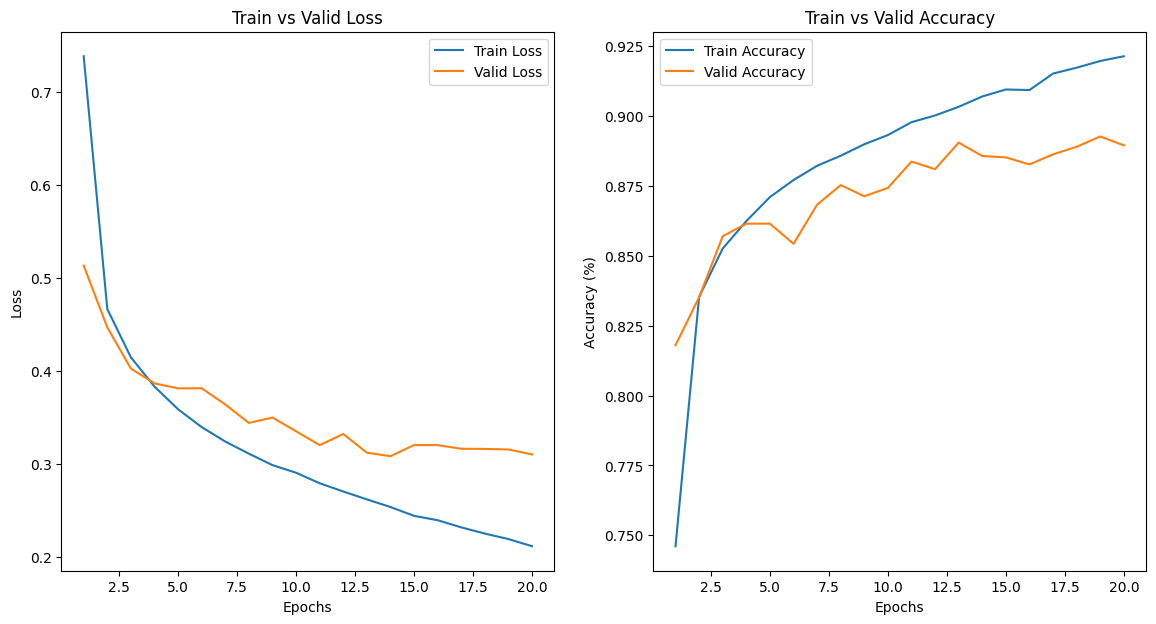

In [ ]:
import matplotlib.pyplot as plt

# Epochs
epochs = range(1, 21)

# Training and validation loss
train_losses = [0.7385, 0.4664, 0.4144, 0.3829, 0.3585, 0.3393, 0.3238, 0.3107, 0.2984, 0.2902,
                0.2789, 0.2700, 0.2615, 0.2533, 0.2438, 0.2391, 0.2314, 0.2247, 0.2188, 0.2111]
valid_losses = [0.5131, 0.4466, 0.4023, 0.3864, 0.3810, 0.3811, 0.3637, 0.3438, 0.3496, 0.3348,
                0.3199, 0.3319, 0.3118, 0.3080, 0.3200, 0.3199, 0.3160, 0.3158, 0.3152, 0.3099]

# Training and validation accuracy
train_accuracies = [0.7461, 0.8353, 0.8526, 0.8624, 0.8710, 0.8771, 0.8822, 0.8858, 0.8899, 0.8932,
                    0.8978, 0.9002, 0.9033, 0.9070, 0.9095, 0.9093, 0.9152, 0.9173, 0.9197, 0.9214]
valid_accuracies = [0.8180, 0.8352, 0.8570, 0.8615, 0.8615, 0.8543, 0.8683, 0.8753, 0.8713, 0.8743,
                    0.8837, 0.8810, 0.8905, 0.8857, 0.8852, 0.8827, 0.8863, 0.8890, 0.8927, 0.8895]

# Plotting loss
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Valid Loss')
plt.title('Train vs Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, valid_accuracies, label='Valid Accuracy')
plt.title('Train vs Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

1) 훈련 손실 감소 : 훈련 데이터에서 점점 더 좋은 성능을 내고 있음을 나타냄.

2) 훈련 정확도 향상 : 모델이 훈련 데이터를 잘 학습하고 있음을 보여줌.

3) 검증 손실도 감소 : 검증 데이터에 대한 모델의 예측 성능이 향상됨.

4) 검증 정확도 향상: 모델이 일반화를 잘 하고 있으며, 새로운 데이터에 대해서도 비교적 정확하게 예측할 수 있음을 시사함.

5) 테스트 데이터셋에 대한 결과: 손실 0.2893 / 정확도 89.63% : 테스트 데이터셋에서도 모델이 비교적 좋은 성능을 보이고 있음.


**미니배치를 사용하지 않고 전체 배치 방식을 사용한 결과 학습속도가 매우 느려진다. (약 27분 소요)**

**전체 배치(full-batch)를 사용할 경우 보다 안정적인 그래디언트 추정이 가능하지만, 매 업데이트마다 전체 데이터셋을 다시 계산해야 하기 때문에 한번의 업데이트에 많은 시간이 소요된다.**

**미니배치 방식은 불안정할 수 있으나 적절한 크기와 파라미터 조정을 통해 전체 배치 방식보다 빠른 수렴을 달성할 수 있다.**

**아래에 이어 minibatch를 사용한 SGD로 코드를 수정하고 train / validation / test에 대한 accuracy를 구하고자 한다.**



---



* minibatch를 사용한 SGD로 코드를 수정하고 train / validation / test에 대한 accuracy를 구하세요 (10)

In [ ]:
# FashionMMIST 데이터셋 로딩
dataset = datasets.FashionMNIST(root='./data', download=True, train=True, transform=transforms.ToTensor())
test_dataset=datasets.FashionMNIST(root='./data', download=True, train=False, transform=transforms.ToTensor())

# 데이터 분할 (data를 8:1:1로 train / validation / test로 분리)
total_train = len(dataset)
train_size = int(total_train * 0.8)
valid_size = int(total_train * 0.1)
test_size = total_train - train_size - valid_size # 정확한 test_size 계산 (모든 데이터의 총합이 1이 되도록 함)

train_dataset, remaining_dataset = random_split(dataset, [train_size, total_train - train_size])
valid_dataset, test_dataset = random_split(remaining_dataset, [valid_size, test_size])

# 훈련 과정에서는 데이터의 다양성을 확보하고 과적합을 방지하기 위해 데이터를 셔플링하고, 검증 및 테스트 단계에서는 모델 성능의 일관된 평가를 위해 셔플링 X
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # minibatch 적용
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False) # minibatch 적용
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False) # minibatch 적용

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# MLP 구현
class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.linear_relu_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10),
    )
  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
model=MLP().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [ ]:
# 학습 함수
def train(model, dataloader, optimizer, criterion):
    model.train() # 모델을 훈련 모드로 설정
    total_loss = 0
    correct = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device) # 데이터를 device 로 이동
        optimizer.zero_grad() # 옵티마이저의 gradient 초기화
        outputs = model(images) # 모델을 통해 예측 수행
        loss = criterion(outputs, labels) # 손실 계산
        loss.backward() # 손실에 대한 gradient 계산
        optimizer.step() # 모델의 파라미터 업데이트
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1) # 가장 높은 점수를 가진 클래스 선택
        correct += (predicted == labels).sum().item() # 정확하게 예측된 샘플 수
    accuracy = correct / len(dataloader.dataset) # 정확도 계산
    return total_loss / len(dataloader), accuracy # 평균 손실과 정확도 반환

# 평가 함수
def evaluate(model, dataloader, criterion):
    model.eval() # 모델을 평가 모드로 설정
    total_loss = 0
    correct = 0
    with torch.no_grad(): # gradient 계산을 비활성화
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

# 모델 학습 및 평가
for epoch in range(20):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion)
    print("=====")
    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

# 테스트 데이터에 대한 평가
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print("=====")
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

=====
Epoch 1
Train Loss: 2.2534, Train Accuracy: 0.2225
Valid Loss: 2.1937, Valid Accuracy: 0.3292
=====
Epoch 2
Train Loss: 2.1172, Train Accuracy: 0.4251
Valid Loss: 2.0220, Valid Accuracy: 0.5057
=====
Epoch 3
Train Loss: 1.8979, Train Accuracy: 0.5389
Valid Loss: 1.7529, Valid Accuracy: 0.5665
=====
Epoch 4
Train Loss: 1.6116, Train Accuracy: 0.6018
Valid Loss: 1.4720, Valid Accuracy: 0.6107
=====
Epoch 5
Train Loss: 1.3620, Train Accuracy: 0.6319
Valid Loss: 1.2638, Valid Accuracy: 0.6352
=====
Epoch 6
Train Loss: 1.1852, Train Accuracy: 0.6475
Valid Loss: 1.1210, Valid Accuracy: 0.6403
=====
Epoch 7
Train Loss: 1.0639, Train Accuracy: 0.6561
Valid Loss: 1.0237, Valid Accuracy: 0.6568
=====
Epoch 8
Train Loss: 0.9783, Train Accuracy: 0.6659
Valid Loss: 0.9531, Valid Accuracy: 0.6663
=====
Epoch 9
Train Loss: 0.9159, Train Accuracy: 0.6758
Valid Loss: 0.9012, Valid Accuracy: 0.6758
=====
Epoch 10
Train Loss: 0.8686, Train Accuracy: 0.6849
Valid Loss: 0.8606, Valid Accuracy: 0.6800

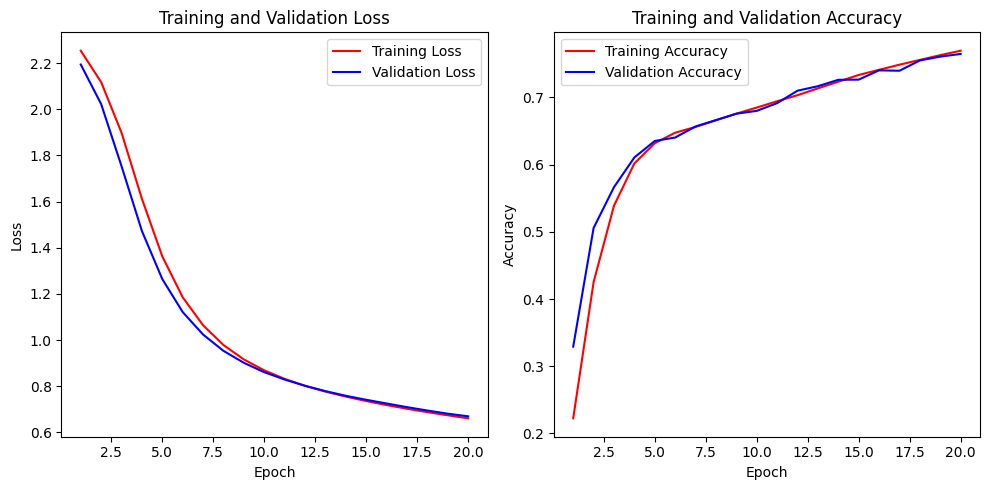

In [ ]:
import matplotlib.pyplot as plt

# 에포크 설정
epochs = range(1, 21)

# 훈련 및 검증 손실
train_losses = [2.2534, 2.1172, 1.8979, 1.6116, 1.3620, 1.1852, 1.0639, 0.9783, 0.9159, 0.8686,
                0.8317, 0.8017, 0.7765, 0.7549, 0.7357, 0.7183, 0.7023, 0.6876, 0.6739, 0.6608]
valid_losses = [2.1937, 2.0220, 1.7529, 1.4720, 1.2638, 1.1210, 1.0237, 0.9531, 0.9012, 0.8606,
                0.8289, 0.8017, 0.7787, 0.7585, 0.7412, 0.7251, 0.7093, 0.6946, 0.6809, 0.6695]

# 훈련 및 검증 정확도
train_accuracies = [0.2225, 0.4251, 0.5389, 0.6018, 0.6319, 0.6475, 0.6561, 0.6659, 0.6758, 0.6849,
                    0.6943, 0.7033, 0.7135, 0.7234, 0.7334, 0.7411, 0.7487, 0.7558, 0.7629, 0.7695]
valid_accuracies = [0.3292, 0.5057, 0.5665, 0.6107, 0.6352, 0.6403, 0.6568, 0.6663, 0.6758, 0.6800,
                    0.6915, 0.7100, 0.7167, 0.7262, 0.7265, 0.7403, 0.7397, 0.7550, 0.7607, 0.7647]

# 손실 그래프
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Training Loss')
plt.plot(epochs, valid_losses, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
plt.plot(epochs, valid_accuracies, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

>모델이 점차적으로 학습하면서 성능이 개선되고 있음을 보임. 모델의 훈련 손실은 점점 감소하고, 훈련 정확도와 검증 정확도는 증가하는 추세를 보임.

>최종 테스트 결과: 최종 에포크에서의 테스트 손실은 0.6525, 테스트 정확도는 77.78%

>이는 모델이 새로운, 보지 못한 데이터에 대해서도 좋은 성능을 보여주고 있음을 의미함.

Minibatch 사용 유무는 머신 러닝에서 특히 딥러닝 모델을 학습시킬 때 매우 중요한 선택 요소이며 모델 학습 과정에 큰 영향을 미친다.

> Minibatch 학습이란?
Minibatch 학습은 전체 훈련 데이터셋을 작은 배치(batch)들로 나누고, 각 배치에 대해 모델의 파라미터를 업데이트하는 방법으로 일반적으로 미니배치 경사 하강법(Minibatch Gradient Descent)라고 불리며, 각 스텝에서 전체 데이터셋의 일부만 사용하여 파라미터를 업데이트한다.

**Minibatch를 사용할 경우 전체 데이터셋을 메모리에 한 번에 로드할 필요가 없기 때문에, 큰 데이터셋을 다룰 때 메모리 사용을 최적화할 수 있다. 더불어, 매우 큰 데이터셋을 사용할 때 모델이 빠르게 학습할 수 있도록 해준다.**


### 미니배치 사용 x, 전체 배치 사용
- 미니배치를 사용하지 않고 전체 배치 방식을 사용한 결과 학습속도가 매우 느림. (약 27분 소요)

- 전체 배치(full-batch)를 사용할 경우 보다 안정적인 그래디언트 추정이 가능

  => 최종 에포크에서의 테스트 손실은 0.2893, 테스트 정확도는 89.63%

- 매 업데이트마다 전체 데이터셋을 다시 계산해야 하기 때문에 한번의 업데이트에 많은 시간이 소요된다.

### 미니배치 사용 O

- 미니배치 방식은 불안정할 수 있으나 적절한 크기와 파라미터 조정을 통해 전체 배치 방식보다 빠른 수렴을 달성할 수 있다. (약 2분 소요)

  => 최종 에포크에서의 테스트 손실은 0.6525, 테스트 정확도는 77.78%


**결론적으로, 전체 배치 학습은 특정 상황에서는 이점을 제공할 수 있지만, 대부분의 경우 미니배치 학습이 더 빠르고 효율적이다. 따라서 대규모 데이터셋과 복잡한 모델에는 미니배치 방식이 널리 사용되고 추천된다.**

더불어, 모델 성능을 더 향상시키기 위해 하이퍼파라미터 튜닝 혹은 다른 학습 기법 등을 시도해 볼 수 있다. 아래에 이어서 모델의 성능을 향상시키는 방법들을 시도하고자 한다.



---



* data normalization을 적용 했을 때 어떤 변화가 있는지 epoch / loss plot을 그려서 비교하세요 (10)

데이터 정규화의 영향을 비교하기 위해 정규화를 적용한 경우와 적용하지 않은 경우에 대해 모델을 훈련시킨 후, 각각의 손실(loss)을 epoch에 따라 기록하고 비교하는 그래프를 그린다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

1) 데이터 정규화를 적용하지 않은 데이터 로딩

In [ ]:
# 데이터 정규화를 적용하지 않은 데이터 로딩
dataset = datasets.FashionMNIST(root='./data', download=True, train=True, transform=transforms.ToTensor()) # No normalization
test_dataset=datasets.FashionMNIST(root='./data', download=True, train=False, transform=transforms.ToTensor()) # No normalization

# 데이터 분할 (data를 8:1:1로 train / validation / test로 분리)
total_train = len(dataset)
train_size = int(total_train * 0.8)
valid_size = int(total_train * 0.1)
test_size = total_train - train_size - valid_size # 정확한 test_size 계산 (모든 데이터의 총합이 1이 되도록 함)

train_dataset, remaining_dataset = random_split(dataset, [train_size, total_train - train_size])
valid_dataset, test_dataset = random_split(remaining_dataset, [valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


2) 정규화 적용 데이터 로딩

In [ ]:
transform_normalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize data
])
normalized_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_normalized)
normalized_test_dataset=datasets.FashionMNIST(root='./data', download=True, train=False, transform=transform_normalized)

normalized_train_dataset, normalized_valid_dataset, normalized_test_dataset = random_split(normalized_dataset, [train_size, valid_size, test_size])

normalized_train_loader = DataLoader(normalized_train_dataset, batch_size=64, shuffle=True)
normalized_valid_loader = DataLoader(normalized_valid_dataset, batch_size=64, shuffle=False)
normalized_test_loader = DataLoader(normalized_test_dataset, batch_size=64, shuffle=False)

모델 정의 및 훈련 함수

In [ ]:
# MLP 구현
class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.linear_relu_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10),
    )
  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [ ]:
# 훈련 함수
def train_model(model, train_loader, epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, targets in train_loader:
            data, targets = data.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")), targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss / len(train_loader))
    return losses

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# 모델 훈련 및 손실 추적
model = MLP().to(device)
losses = train_model(model, train_loader)

normalized_model = MLP().to(device)
normalized_losses = train_model(normalized_model, normalized_train_loader)

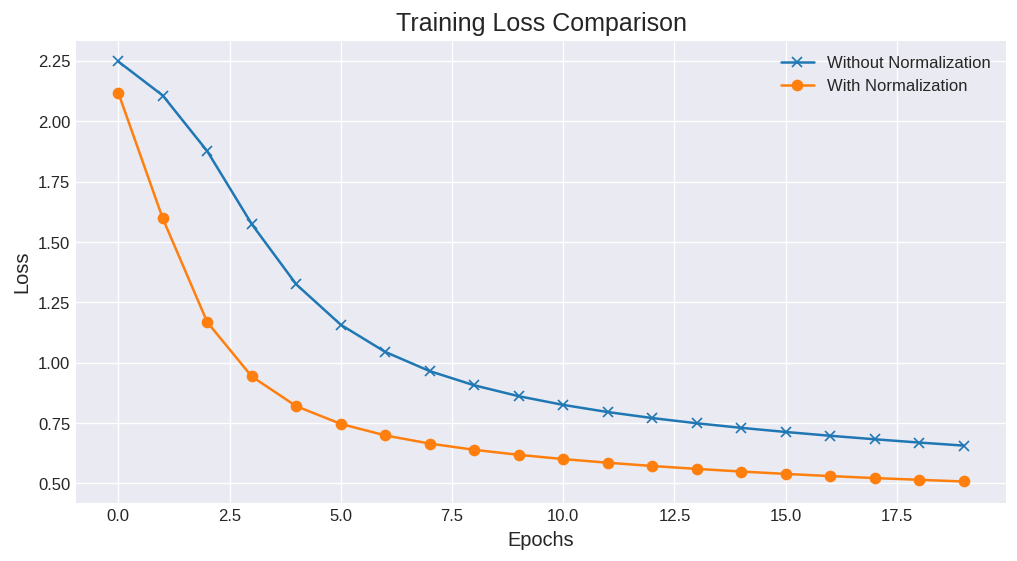

In [ ]:
# 손실 그래프 그리기
plt.figure(figsize=(10, 5), dpi=120)
plt.plot(losses, label='Without Normalization', marker='x')
plt.plot(normalized_losses, label='With Normalization', marker='o')
plt.title('Training Loss Comparison', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.show()

### 정규화 사용 O vs 정규화 사용 X
- 정규화 사용 시 손실 감소 속도가 빠름. 정규화를 적용한 모델이 초기 에포크에서 손실이 더 빠르게 감소함.

  => 정규화가 모델이 데이터를 더 효과적으로 학습하도록 도와주며, 최적의 가중치에 더욱 빨리 수렴할 수 있게 함을 시사함.

- 정규화 사용 시 손실 감소의 안정성을 보임. 정규화를 적용하지 않은 모델에 비해 손실 감소가 일관적인 경향을 보임.

**이를 통해, 정규화가 딥러닝 모델의 학습 과정에 긍정적인 영향을 미칠 수 있음을 알 수 있다. 정규화는 각 입력 특성의 스케일을 조정하여, 모델이 더욱 빠르고 안정적으로 최적화할 수 있도록 도와준다.**




---



* optimizer를 SGD / SGD+Momentum / SGD+Nestrov Momentum / AdaGrad / RMSProp / Adam 를 사용 하였을 때 어떤 결과가 있는지 epoch / loss plot을 그려서 비교하세요. (하나의 plot에 나오도록 해야함) (20)

In [13]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [14]:
import torch.nn.functional as F
import torch.optim as optim

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
# FashionMMIST 데이터셋 로딩
transform= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize data
])
dataset = datasets.FashionMNIST(root='./data', download=True, train=True, transform=transform)
test_dataset=datasets.FashionMNIST(root='./data', download=True, train=False, transform=transform)

# 데이터 분할 (data를 8:1:1로 train / validation / test로 분리)
total_train = len(dataset)
train_size = int(total_train * 0.8)
valid_size = int(total_train * 0.1)
test_size = total_train - train_size - valid_size # 정확한 test_size 계산 (모든 데이터의 총합이 1이 되도록 함)

train_dataset, remaining_dataset = random_split(dataset, [train_size, total_train - train_size])
valid_dataset, test_dataset = random_split(remaining_dataset, [valid_size, test_size])

# 훈련 과정에서는 데이터의 다양성을 확보하고 과적합을 방지하기 위해 데이터를 셔플링하고, 검증 및 테스트 단계에서는 모델 성능의 일관된 평가를 위해 셔플링 X
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [19]:
# MLP 구현
class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.linear_relu_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10),
    )
  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [24]:
# 훈련 함수
def train_model(model, train_loader, optimizer, epochs=20):
    criterion = nn.CrossEntropyLoss()
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    return losses

In [25]:
# 훈련 및 결과 추적
optimizers = {
    'SGD': optim.SGD,
    'SGD_Momentum': lambda params: optim.SGD(params, lr=0.01, momentum=0.9),
    'SGD_Nesterov': lambda params: optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True),
    'AdaGrad': lambda params: optim.Adagrad(params, lr=0.01),
    'RMSProp': lambda params: optim.RMSprop(params, lr=0.01),
    'Adam': lambda params: optim.Adam(params, lr=0.01)
}

results = {}
for name, opt_func in optimizers.items():
    print(f"Training with {name}")
    model = MLP().to(device)
    optimizer = opt_func(model.parameters())
    losses = train_model(model, train_loader, optimizer)
    results[name] = losses

Training with SGD
Epoch 1/20, Loss: 2.0787
Epoch 2/20, Loss: 1.5186
Epoch 3/20, Loss: 1.1137
Epoch 4/20, Loss: 0.9106
Epoch 5/20, Loss: 0.7996
Epoch 6/20, Loss: 0.7329
Epoch 7/20, Loss: 0.6891
Epoch 8/20, Loss: 0.6577
Epoch 9/20, Loss: 0.6334
Epoch 10/20, Loss: 0.6134
Epoch 11/20, Loss: 0.5967
Epoch 12/20, Loss: 0.5820
Epoch 13/20, Loss: 0.5689
Epoch 14/20, Loss: 0.5571
Epoch 15/20, Loss: 0.5466
Epoch 16/20, Loss: 0.5371
Epoch 17/20, Loss: 0.5285
Epoch 18/20, Loss: 0.5205
Epoch 19/20, Loss: 0.5133
Epoch 20/20, Loss: 0.5066
Training with SGD_Momentum
Epoch 1/20, Loss: 0.5801
Epoch 2/20, Loss: 0.3969
Epoch 3/20, Loss: 0.3520
Epoch 4/20, Loss: 0.3249
Epoch 5/20, Loss: 0.3061
Epoch 6/20, Loss: 0.2828
Epoch 7/20, Loss: 0.2702
Epoch 8/20, Loss: 0.2531
Epoch 9/20, Loss: 0.2437
Epoch 10/20, Loss: 0.2333
Epoch 11/20, Loss: 0.2229
Epoch 12/20, Loss: 0.2129
Epoch 13/20, Loss: 0.2023
Epoch 14/20, Loss: 0.1944
Epoch 15/20, Loss: 0.1824
Epoch 16/20, Loss: 0.1745
Epoch 17/20, Loss: 0.1712
Epoch 18/20

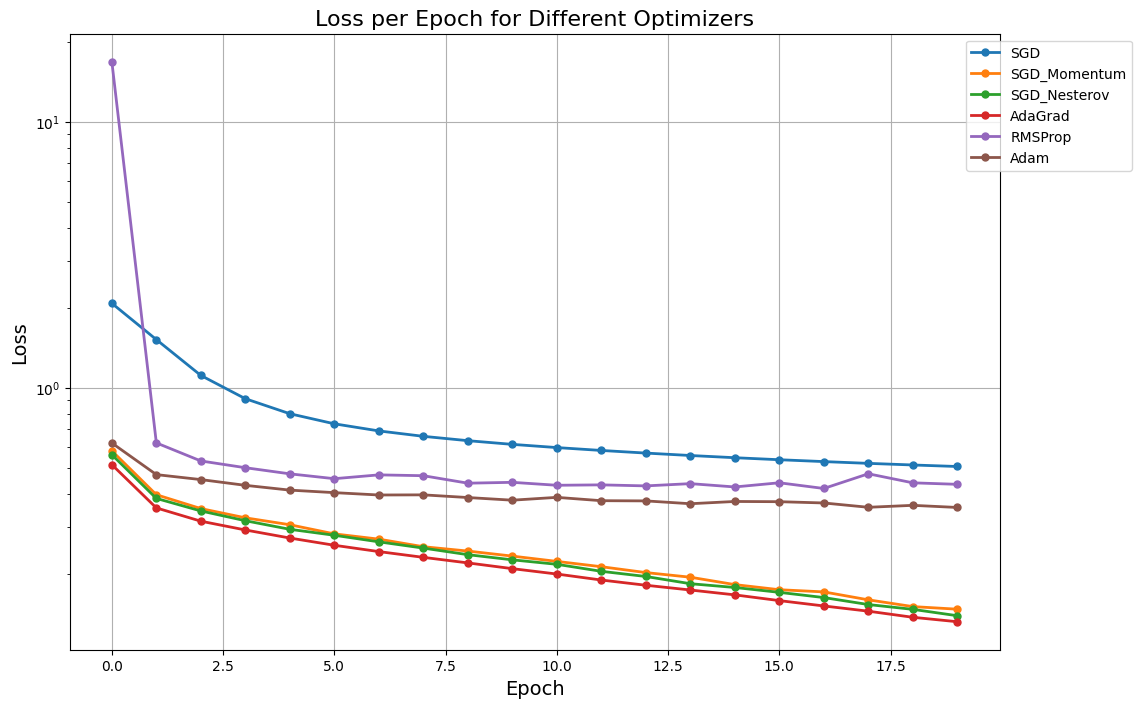

In [28]:
import matplotlib.pyplot as plt

# 결과 플롯
plt.figure(figsize=(12, 8))  # 그래프 크기 조정
for name, losses in results.items():
    plt.plot(losses, label=f'{name}', linewidth=2, marker='o', markersize=5)  # 선 두께 및 마커 설정
plt.title('Loss per Epoch for Different Optimizers', fontsize=16)  # 제목 및 폰트 크기 설정
plt.xlabel('Epoch', fontsize=14)  # X축 레이블
plt.ylabel('Loss', fontsize=14)  # Y축 레이블
plt.yscale('log')  # Y축을 로그 스케일로 변경
plt.grid(True)  # 그리드 추가
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))  # 범례 위치 조정
plt.show()




---



*  Dropout을 적용했을 때 성능 변화를 epoch / loss / accuracy를 사용하여 비교하세요 (10)


In [29]:
# MLP 구현
class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.linear_relu_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Dropout(p=0.5), # Dropout 적용
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Dropout(p=0.5), # Dropout 적용
        nn.Linear(512, 10),
    )
  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
model=MLP().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01) # Adam 사용

In [31]:
# 학습 함수
def train(model, dataloader, optimizer, criterion):
    model.train() # 모델을 훈련 모드로 설정
    total_loss = 0
    correct = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device) # 데이터를 device 로 이동
        optimizer.zero_grad() # 옵티마이저의 gradient 초기화
        outputs = model(images) # 모델을 통해 예측 수행
        loss = criterion(outputs, labels) # 손실 계산
        loss.backward() # 손실에 대한 gradient 계산
        optimizer.step() # 모델의 파라미터 업데이트
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1) # 가장 높은 점수를 가진 클래스 선택
        correct += (predicted == labels).sum().item() # 정확하게 예측된 샘플 수
    accuracy = correct / len(dataloader.dataset) # 정확도 계산
    return total_loss / len(dataloader), accuracy # 평균 손실과 정확도 반환

# 평가 함수
def evaluate(model, dataloader, criterion):
    model.eval() # 모델을 평가 모드로 설정
    total_loss = 0
    correct = 0
    with torch.no_grad(): # gradient 계산을 비활성화
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

# 모델 학습 및 평가
for epoch in range(20):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion)
    print("=====")
    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

# 테스트 데이터에 대한 평가
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print("=====")
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

=====
Epoch 1
Train Loss: 0.6931, Train Accuracy: 0.7462
Valid Loss: 0.5311, Valid Accuracy: 0.8117
=====
Epoch 2
Train Loss: 0.6196, Train Accuracy: 0.7741
Valid Loss: 0.5339, Valid Accuracy: 0.8038
=====
Epoch 3
Train Loss: 0.6142, Train Accuracy: 0.7794
Valid Loss: 0.5201, Valid Accuracy: 0.8063
=====
Epoch 4
Train Loss: 0.6103, Train Accuracy: 0.7813
Valid Loss: 0.5284, Valid Accuracy: 0.8012
=====
Epoch 5
Train Loss: 0.6057, Train Accuracy: 0.7814
Valid Loss: 0.5233, Valid Accuracy: 0.8182
=====
Epoch 6
Train Loss: 0.6008, Train Accuracy: 0.7862
Valid Loss: 0.5076, Valid Accuracy: 0.8118
=====
Epoch 7
Train Loss: 0.6026, Train Accuracy: 0.7845
Valid Loss: 0.5078, Valid Accuracy: 0.8208
=====
Epoch 8
Train Loss: 0.5982, Train Accuracy: 0.7861
Valid Loss: 0.4830, Valid Accuracy: 0.8233
=====
Epoch 9
Train Loss: 0.5971, Train Accuracy: 0.7870
Valid Loss: 0.5068, Valid Accuracy: 0.8120
=====
Epoch 10
Train Loss: 0.5972, Train Accuracy: 0.7869
Valid Loss: 0.5056, Valid Accuracy: 0.8095

* Drop out 사용

Epoch 20

Train Loss: 0.5954, Train Accuracy: 0.7884

Valid Loss: 0.5192, Valid Accuracy: 0.8165

  => Test Loss: 0.5130, Test Accuracy: 0.8213

* Drop out 사용 X

Epoch 20

Train Loss: 0.6608, Train Accuracy: 0.7695

Valid Loss: 0.6695, Valid Accuracy: 0.7647

  => Test Loss: 0.6525, Test Accuracy: 0.7778

드롭아웃을 적용했을 때, 모든 평가 지표에서 성능이 향상된 것을 볼 수 있다. 드롭아웃을 사용하지 않았을 때 대비 훈련, 검증, 테스트의 손실이 모두 낮아졌고, 정확도 또한 전반적으로 개선되었다. 특히 테스트 정확도에서 약 4% 이상의 개선이 관찰된다.

이는 드롭아웃이 모델의 과적합을 방지하고, 더 일반화된 모델을 만드는 데 도움을 준다는 것을 보여준다. 훈련 과정에서 일부 뉴런의 활성을 무작위로 제거함으로써, 모델이 훈련 데이터의 잡음에 덜 민감하게 반응하고, 실제 세계 데이터에 대해 더 강력하고 안정적으로 예측할 수 있게 된다.



---



* MLP model에 batch normalization layer를 추가 했을 때 어떤 변화가 있는지 답하세요 (10)

In [32]:
# MLP 구현
class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.linear_relu_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 512),
        nn.BatchNorm1d(512), # batch normalization layer 추가
        nn.ReLU(),
        nn.Dropout(p=0.5), # Dropout 적용
        nn.Linear(512, 512),
        nn.BatchNorm1d(512), # batch normalization layer 추가
        nn.ReLU(),
        nn.Dropout(p=0.5), # Dropout 적용
        nn.Linear(512, 10),
    )
  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
model=MLP().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01) # Adam 사용

In [34]:
# 학습 함수
def train(model, dataloader, optimizer, criterion):
    model.train() # 모델을 훈련 모드로 설정
    total_loss = 0
    correct = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device) # 데이터를 device 로 이동
        optimizer.zero_grad() # 옵티마이저의 gradient 초기화
        outputs = model(images) # 모델을 통해 예측 수행
        loss = criterion(outputs, labels) # 손실 계산
        loss.backward() # 손실에 대한 gradient 계산
        optimizer.step() # 모델의 파라미터 업데이트
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1) # 가장 높은 점수를 가진 클래스 선택
        correct += (predicted == labels).sum().item() # 정확하게 예측된 샘플 수
    accuracy = correct / len(dataloader.dataset) # 정확도 계산
    return total_loss / len(dataloader), accuracy # 평균 손실과 정확도 반환

# 평가 함수
def evaluate(model, dataloader, criterion):
    model.eval() # 모델을 평가 모드로 설정
    total_loss = 0
    correct = 0
    with torch.no_grad(): # gradient 계산을 비활성화
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

# 모델 학습 및 평가
for epoch in range(20):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion)
    print("=====")
    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

# 테스트 데이터에 대한 평가
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print("=====")
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

=====
Epoch 1
Train Loss: 0.6115, Train Accuracy: 0.7843
Valid Loss: 0.5122, Valid Accuracy: 0.8228
=====
Epoch 2
Train Loss: 0.5889, Train Accuracy: 0.7995
Valid Loss: 0.5587, Valid Accuracy: 0.8187
=====
Epoch 3
Train Loss: 0.5993, Train Accuracy: 0.8011
Valid Loss: 0.5648, Valid Accuracy: 0.8047
=====
Epoch 4
Train Loss: 0.6011, Train Accuracy: 0.7971
Valid Loss: 0.5015, Valid Accuracy: 0.8312
=====
Epoch 5
Train Loss: 0.5983, Train Accuracy: 0.8015
Valid Loss: 0.5375, Valid Accuracy: 0.8153
=====
Epoch 6
Train Loss: 0.5986, Train Accuracy: 0.8007
Valid Loss: 0.5145, Valid Accuracy: 0.8287
=====
Epoch 7
Train Loss: 0.5950, Train Accuracy: 0.8016
Valid Loss: 0.5205, Valid Accuracy: 0.8255
=====
Epoch 8
Train Loss: 0.5986, Train Accuracy: 0.8015
Valid Loss: 0.6033, Valid Accuracy: 0.7857
=====
Epoch 9
Train Loss: 0.5965, Train Accuracy: 0.8011
Valid Loss: 0.5185, Valid Accuracy: 0.8262
=====
Epoch 10
Train Loss: 0.5986, Train Accuracy: 0.8005
Valid Loss: 0.5121, Valid Accuracy: 0.8295

* batch normalization layer를 추가 X

Epoch 20

Train Loss: 0.5954, Train Accuracy: 0.7884

Valid Loss: 0.5192, Valid Accuracy: 0.8165

=> Test Loss: 0.5130, Test Accuracy: 0.8213

* batch normalization layer를 추가 O

Epoch 20

Train Loss: 0.5945, Train Accuracy: 0.8042

Valid Loss: 0.4934, Valid Accuracy: 0.8282

=> Test Loss: 0.4821, Test Accuracy: 0.8373




---



* 위의 방법들과 hyper parameter tuning을 통해 모델의 성능을 향상시키고 결과를 report 하세요 (30)

In [35]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [36]:
import torch.nn.functional as F
import torch.optim as optim

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [38]:
# FashionMMIST 데이터셋 로딩
transform= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize data
])
dataset = datasets.FashionMNIST(root='./data', download=True, train=True, transform=transform)
test_dataset=datasets.FashionMNIST(root='./data', download=True, train=False, transform=transform)

# 데이터 분할 (data를 8:1:1로 train / validation / test로 분리)
total_train = len(dataset)
train_size = int(total_train * 0.8)
valid_size = int(total_train * 0.1)
test_size = total_train - train_size - valid_size # 정확한 test_size 계산 (모든 데이터의 총합이 1이 되도록 함)

train_dataset, remaining_dataset = random_split(dataset, [train_size, total_train - train_size])
valid_dataset, test_dataset = random_split(remaining_dataset, [valid_size, test_size])

# 훈련 과정에서는 데이터의 다양성을 확보하고 과적합을 방지하기 위해 데이터를 셔플링하고, 검증 및 테스트 단계에서는 모델 성능의 일관된 평가를 위해 셔플링 X
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # minibatch 사용
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False) # minibatch 사용
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False) # minibatch 사용

In [39]:
# MLP 구현
class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.linear_relu_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 512),
        nn.BatchNorm1d(512), # batch normalization layer 추가
        nn.ReLU(),
        nn.Dropout(p=0.5), # Dropout 적용
        nn.Linear(512, 512),
        nn.BatchNorm1d(512), # batch normalization layer 추가
        nn.ReLU(),
        nn.Dropout(p=0.5), # Dropout 적용
        nn.Linear(512, 10),
    )
  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
model=MLP().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01) # 최적화 함수 Adam 사용

In [41]:
# 학습 함수
def train(model, dataloader, optimizer, criterion):
    model.train() # 모델을 훈련 모드로 설정
    total_loss = 0
    correct = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device) # 데이터를 device 로 이동
        optimizer.zero_grad() # 옵티마이저의 gradient 초기화
        outputs = model(images) # 모델을 통해 예측 수행
        loss = criterion(outputs, labels) # 손실 계산
        loss.backward() # 손실에 대한 gradient 계산
        optimizer.step() # 모델의 파라미터 업데이트
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1) # 가장 높은 점수를 가진 클래스 선택
        correct += (predicted == labels).sum().item() # 정확하게 예측된 샘플 수
    accuracy = correct / len(dataloader.dataset) # 정확도 계산
    return total_loss / len(dataloader), accuracy # 평균 손실과 정확도 반환

# 평가 함수
def evaluate(model, dataloader, criterion):
    model.eval() # 모델을 평가 모드로 설정
    total_loss = 0
    correct = 0
    with torch.no_grad(): # gradient 계산을 비활성화
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

# 모델 학습 및 평가
for epoch in range(20):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion)
    print("=====")
    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

# 테스트 데이터에 대한 평가
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print("=====")
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

=====
Epoch 1
Train Loss: 0.6058, Train Accuracy: 0.7880
Valid Loss: 0.5181, Valid Accuracy: 0.8145
=====
Epoch 2
Train Loss: 0.5849, Train Accuracy: 0.8016
Valid Loss: 0.5150, Valid Accuracy: 0.8220
=====
Epoch 3
Train Loss: 0.5995, Train Accuracy: 0.7994
Valid Loss: 0.5613, Valid Accuracy: 0.8113
=====
Epoch 4
Train Loss: 0.5979, Train Accuracy: 0.8006
Valid Loss: 0.4953, Valid Accuracy: 0.8313
=====
Epoch 5
Train Loss: 0.5997, Train Accuracy: 0.8003
Valid Loss: 0.5401, Valid Accuracy: 0.8118
=====
Epoch 6
Train Loss: 0.5933, Train Accuracy: 0.8008
Valid Loss: 0.5019, Valid Accuracy: 0.8280
=====
Epoch 7
Train Loss: 0.5996, Train Accuracy: 0.7999
Valid Loss: 0.4954, Valid Accuracy: 0.8373
=====
Epoch 8
Train Loss: 0.5980, Train Accuracy: 0.8018
Valid Loss: 0.5083, Valid Accuracy: 0.8248
=====
Epoch 9
Train Loss: 0.5990, Train Accuracy: 0.7997
Valid Loss: 0.4959, Valid Accuracy: 0.8348
=====
Epoch 10
Train Loss: 0.5976, Train Accuracy: 0.8009
Valid Loss: 0.5074, Valid Accuracy: 0.8267

학습률 0.001의 잠재적 이점

1) 더 낮은 학습률은 파라미터 업데이트가 더 작고, 점진적으로 이루어지기 때문에 학습 과정이 더 안정적일 수 있다.

2) 과적합 방지: 낮은 학습률은 과적합을 방지하는 데 도움을 줄 수 있으며, 검증 손실(validation loss)의 감소가 훈련 손실(training loss)보다 느리지 않게 만들 수 있다.

학습률을 0.001로 설정함에 따라 여러 요인들을 고려하여 epoch를 20으로 설정함.